In [1]:
# Version 2.0
# Here we try xgboost (inspired by gradient boosting) and tune the parameters for higher auc score

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, ensemble
from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, GridSearchCV
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
def read_file(filename):
    raw_data = pd.read_csv(filename)
    data = raw_data.copy()
    return data

In [3]:
# read in train and test data -> X_train, y_train, X_test (pd.df)
train_path = "train_2008.csv"
test_path = "test_2008.csv"
train_data = read_file(train_path)
test_data = read_file(test_path)
y_train = train_data['target']
X_train = train_data.drop(['target', 'id'], axis=1)
X_test = test_data
X_test = X_test.drop('id', axis=1)

In [4]:
def select_same_resp_feature(X):
    same_resp_feature = []
    for feature in X.columns:
        if len(np.unique(X[feature])) == 1:
            same_resp_feature.append(feature)
    print(len(same_resp_feature))
    return same_resp_feature

def select_low_resp_feature(X):
    resp_rate = X_train[X_train >= 0].count() / len(X_train)
    low_resp_features = []
    for cnt in resp_rate.items():
        if cnt[1] < 0.01:
            low_resp_features.append(cnt[0])
    print(len(low_resp_features))
    return low_resp_features

In [5]:
same_resp_feature = select_same_resp_feature(X_train)
X_train.drop(same_resp_feature, axis=1, inplace=True)
X_test.drop(same_resp_feature, axis=1, inplace=True)

15


In [8]:
low_resp_features = select_low_resp_feature(X_train)
X_train.drop(mostly_blank_feats, axis=1, inplace=True)
X_test.drop(mostly_blank_feats, axis=1, inplace=True)

NameError: name 'resp_rate' is not defined

In [ ]:
# recode the strongly unbalanced features to binary {1, 0}
for i in X_train.columns:
    cols = X_train[i]
    freq_out = cols.value_counts(normalize=True)
    if freq_out.max() > 0.95:
        max_idx = freq_out.idxmax()
        X_train[i] = X_train[i].apply(lambda x: 1 if (x == max_idx) else 0)
        X_test[i] = X_test[i].apply(lambda x: 1 if (x == max_idx) else 0)

In [6]:
# map all the -1 to NaN
for feature in X_train.columns:
    X_train[feature] = X_train[feature].apply(lambda x: np.NaN if (x == -1) else x)
    X_test[feature] = X_test[feature].apply(lambda x: np.NaN if (x == -1) else x)

In [ ]:
# categorical features (one-hot encoding)
categorical_features = ['HUFINAL','GEREG', 'HUBUS', 'PTDTRACE', 'PENATVTY', 'PUABSOT', 'PEIO1COW', 
                        'HUFINAL', 'GESTCEN', 'GESTFIPS', 'PRCITSHP', 'PUDIS', 'PRABSREA', 'PRWKSTAT', 'HUPRSCNT', 
                        'PERRP', 'GTCBSAST', 'PRMJOCGR', 'HRHTYPE', ]
train_dummy = pd.DataFrame()
test_dummy = pd.DataFrame()
for feature in categorical_features:
    train_dummy_tmp = pd.get_dummies(X_train[feature], prefix=feature)
    train_dummy = pd.concat([train_dummy, train_dummy_tmp], axis=1)
    test_dummy_tmp = pd.get_dummies(X_test[feature], prefix=feature)
    test_dummy = pd.concat([test_dummy, test_dummy_tmp], axis=1)
X_train.drop(categorical_features, axis=1, inplace=True)
X_test.drop(categorical_features, axis=1, inplace=True)
X_train = pd.concat([X_train, train_dummy], axis=1)
X_test = pd.concat([X_test, test_dummy], axis=1)

In [ ]:
train_add_features = [f for f in X_test.columns if f not in X_train.columns]
test_add_features = [f for f in X_train.columns if f not in X_test.columns]
for feature in train_add_features:
    X_train[feature] = 0
for feature in test_add_features:
    X_test[feature] = 0

In [7]:
X = X_train.values
Y = y_train.values
X_t = X_test.values
print(X.shape)
print(Y.shape)
print(X_t.shape)

(64667, 366)
(64667,)
(16000, 366)


In [12]:
def cross_validation(X, num_folds, clf):
    kf = model_selection.KFold(n_splits=num_folds)
    train_auc_ls = []
    valid_auc_ls = []
    for train_index, valid_index in kf.split(X):
        print("1...")
        print("TRAIN:", train_index, "VALIDATION:", valid_index)
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = Y[train_index], Y[valid_index]
        clf.fit(X_train, y_train)
        y_train_pred = clf.predict_proba(X_train)[:, 1]
        y_valid_pred = clf.predict_proba(X_valid)[:, 1]
        train_auc = metrics.roc_auc_score(y_train, y_train_pred)
        valid_auc = metrics.roc_auc_score(y_valid, y_valid_pred)
        train_auc_ls.append(train_auc)
        valid_auc_ls.append(valid_auc)
        print("2...")
    return train_auc_ls, valid_auc_ls, clf

In [13]:
num_folds = 3
number_of_estimators = range(20, 180, 50)
gamma = [0.1, 0.3, 0.4]
max_depth = [6, 8, 9, 10]
subsample = [0.5, 0.7, 0.8, 1.0]

In [14]:
valid_auc = []
for n in number_of_estimators:
    clf = XGBClassifier(n_estimators=n, colsample_bytree = 0.8, objective='binary:logistic') 
    train_auc_ls, valid_auc_ls, clf = cross_validation(X, num_folds, clf)
    valid_auc.append(np.mean(valid_auc_ls))

1...
TRAIN: [21556 21557 21558 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 21553 21554 21555]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [21556 21557 21558 ... 43109 43110 43111]
2...
1...
TRAIN: [    0     1     2 ... 43109 43110 43111] VALIDATION: [43112 43113 43114 ... 64664 64665 64666]
2...
1...
TRAIN: [21556 21557 21558 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 21553 21554 21555]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [21556 21557 21558 ... 43109 43110 43111]
2...
1...
TRAIN: [    0     1     2 ... 43109 43110 43111] VALIDATION: [43112 43113 43114 ... 64664 64665 64666]
2...
1...
TRAIN: [21556 21557 21558 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 21553 21554 21555]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [21556 21557 21558 ... 43109 43110 43111]
2...
1...
TRAIN: [    0     1     2 ... 43109 43110 43111] VALIDATION: [43112 43113 43114 ... 64664 6

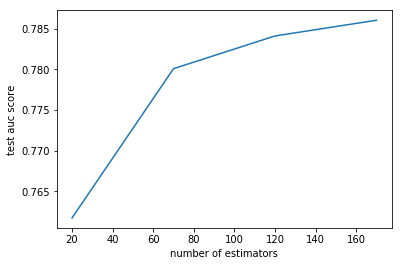

In [15]:
plt.figure()
plt.plot(number_of_estimators, valid_auc)
plt.xlabel("number of estimators")
plt.ylabel("test auc score")
plt.show()

In [17]:
valid_auc = []
for g in gamma:
    clf = XGBClassifier(n_estimators=150, gamma=g, colsample_bytree = 0.8, objective='binary:logistic') 
    train_auc_ls, valid_auc_ls, clf = cross_validation(X, num_folds, clf)
    valid_auc.append(np.mean(valid_auc_ls))

1...
TRAIN: [21556 21557 21558 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 21553 21554 21555]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [21556 21557 21558 ... 43109 43110 43111]
2...
1...
TRAIN: [    0     1     2 ... 43109 43110 43111] VALIDATION: [43112 43113 43114 ... 64664 64665 64666]
2...
1...
TRAIN: [21556 21557 21558 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 21553 21554 21555]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [21556 21557 21558 ... 43109 43110 43111]
2...
1...
TRAIN: [    0     1     2 ... 43109 43110 43111] VALIDATION: [43112 43113 43114 ... 64664 64665 64666]
2...
1...
TRAIN: [21556 21557 21558 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 21553 21554 21555]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [21556 21557 21558 ... 43109 43110 43111]
2...
1...
TRAIN: [    0     1     2 ... 43109 43110 43111] VALIDATION: [43112 43113 43114 ... 64664 6

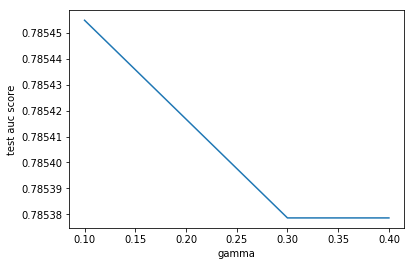

In [18]:
plt.figure()
plt.plot(gamma, valid_auc)
plt.xlabel("gamma")
plt.ylabel("test auc score")
plt.show()

In [19]:
valid_auc = []
for d in max_depth:
    clf = XGBClassifier(n_estimators=150, gamma=0.1, max_depth=d, colsample_bytree = 0.8, objective='binary:logistic') 
    train_auc_ls, valid_auc_ls, clf = cross_validation(X, num_folds, clf)
    valid_auc.append(np.mean(valid_auc_ls))

1...
TRAIN: [21556 21557 21558 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 21553 21554 21555]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [21556 21557 21558 ... 43109 43110 43111]
2...
1...
TRAIN: [    0     1     2 ... 43109 43110 43111] VALIDATION: [43112 43113 43114 ... 64664 64665 64666]
2...
1...
TRAIN: [21556 21557 21558 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 21553 21554 21555]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [21556 21557 21558 ... 43109 43110 43111]
2...
1...
TRAIN: [    0     1     2 ... 43109 43110 43111] VALIDATION: [43112 43113 43114 ... 64664 64665 64666]
2...
1...
TRAIN: [21556 21557 21558 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 21553 21554 21555]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [21556 21557 21558 ... 43109 43110 43111]
2...
1...
TRAIN: [    0     1     2 ... 43109 43110 43111] VALIDATION: [43112 43113 43114 ... 64664 6

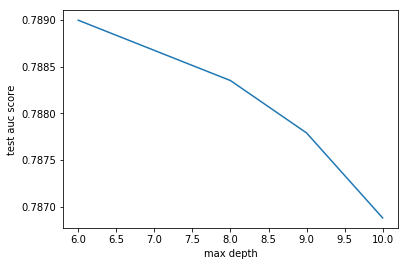

In [20]:
plt.figure()
plt.plot(max_depth, valid_auc)
plt.xlabel("max depth")
plt.ylabel("test auc score")
plt.show()

In [22]:
valid_auc = []
for s in subsample:
    clf = XGBClassifier(n_estimators=150, gamma=0.1, max_depth=6, subsample=s, colsample_bytree = 0.8, objective='binary:logistic') 
    train_auc_ls, valid_auc_ls, clf = cross_validation(X, num_folds, clf)
    valid_auc.append(np.mean(valid_auc_ls))

1...
TRAIN: [21556 21557 21558 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 21553 21554 21555]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [21556 21557 21558 ... 43109 43110 43111]
2...
1...
TRAIN: [    0     1     2 ... 43109 43110 43111] VALIDATION: [43112 43113 43114 ... 64664 64665 64666]
2...
1...
TRAIN: [21556 21557 21558 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 21553 21554 21555]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [21556 21557 21558 ... 43109 43110 43111]
2...
1...
TRAIN: [    0     1     2 ... 43109 43110 43111] VALIDATION: [43112 43113 43114 ... 64664 64665 64666]
2...
1...
TRAIN: [21556 21557 21558 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 21553 21554 21555]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [21556 21557 21558 ... 43109 43110 43111]
2...
1...
TRAIN: [    0     1     2 ... 43109 43110 43111] VALIDATION: [43112 43113 43114 ... 64664 6

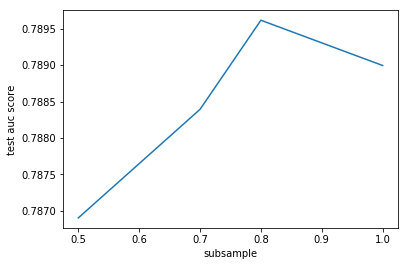

In [23]:
plt.figure()
plt.plot(subsample, valid_auc)
plt.xlabel("subsample")
plt.ylabel("test auc score")
plt.show()

In [24]:
valid_auc = []
max_depth = [6, 8, 9, 10]
for d in max_depth:
    clf = XGBClassifier(n_estimators=150, gamma=0.3, max_depth=d, subsample=0.8, colsample_bytree = 0.8, objective='binary:logistic') 
    train_auc_ls, valid_auc_ls, clf = cross_validation(X, num_folds, clf)
    valid_auc.append(np.mean(valid_auc_ls))

1...
TRAIN: [21556 21557 21558 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 21553 21554 21555]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [21556 21557 21558 ... 43109 43110 43111]
2...
1...
TRAIN: [    0     1     2 ... 43109 43110 43111] VALIDATION: [43112 43113 43114 ... 64664 64665 64666]
2...
1...
TRAIN: [21556 21557 21558 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 21553 21554 21555]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [21556 21557 21558 ... 43109 43110 43111]
2...
1...
TRAIN: [    0     1     2 ... 43109 43110 43111] VALIDATION: [43112 43113 43114 ... 64664 64665 64666]
2...
1...
TRAIN: [21556 21557 21558 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 21553 21554 21555]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [21556 21557 21558 ... 43109 43110 43111]
2...
1...
TRAIN: [    0     1     2 ... 43109 43110 43111] VALIDATION: [43112 43113 43114 ... 64664 6

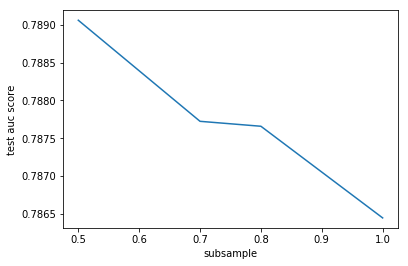

In [25]:
plt.figure()
plt.plot(subsample, valid_auc)
plt.xlabel("subsample")
plt.ylabel("test auc score")
plt.show()